In [11]:
import sys
sys.path.insert(0, '../')

import utils
from JR_Scripts import dict_reader, time_toy_generator
from model import WGanModel, WNGanModel, TemporalGanModelv3
from gan import GAN
import tensorflow as tf
import numpy as np
from PIL import Image
import imageio
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
params = dict()
params['num_gaussians'] = 42
params['num_classes'] = 10
image_sizes = [128,256,512]


In [12]:
def gen_data(image_size, n):
    num_gaussians = 42
    if 'num_gaussians' in params:
        num_gaussians = params['num_gaussians']

    # Generate data
    data = time_toy_generator.gen_dataset_continuous(images_per_time_step=n,
                                      width=image_size,
                                      num_gaussians=num_gaussians,
                                      point_density_factor=3)
    # Prep data
    data = data.swapaxes(0,1)
    data = data.reshape((data.shape[0] * data.shape[1], data.shape[2], data.shape[3]))
    data = data.astype(np.float32)
    data = utils.forward_map(data, 1)
    data = data / 1.02
    return data

def wasserstein_distance(x_og, y, w):
    assert(x_og.shape == y.shape == w.shape)
    x = np.copy(x_og)
    loss = 0
    for idx in range(x.shape[0] - 1):
        d = y[idx] - x[idx]
        x[idx] = x[idx] + d
        x[idx+1] = x[idx+1] - d
        loss = loss + np.abs(d * (w[idx+1] - w[idx]))
    return loss / (w[-1] - w[0])

def get_cmap(name, n_colors):
    cmap = cm.get_cmap(name, n_colors)
    return cmap(np.arange(n_colors))
cmap = get_cmap('winter', 10)

In [4]:
data_lst = []
for image_size in image_sizes:
    data = gen_data(image_size, 100)
    data_lst.append(data)

completed 5 image series
completed 10 image series
completed 15 image series
completed 20 image series
completed 25 image series
completed 30 image series
completed 35 image series
completed 40 image series
completed 45 image series
completed 50 image series
completed 55 image series
completed 60 image series
completed 65 image series
completed 70 image series
completed 75 image series
completed 80 image series
completed 85 image series
completed 90 image series
completed 95 image series
completed 100 image series
completed 5 image series
completed 10 image series
completed 15 image series
completed 20 image series
completed 25 image series
completed 30 image series
completed 35 image series
completed 40 image series
completed 45 image series
completed 50 image series
completed 55 image series
completed 60 image series
completed 65 image series
completed 70 image series
completed 75 image series
completed 80 image series
completed 85 image series
completed 90 image series
completed 95 

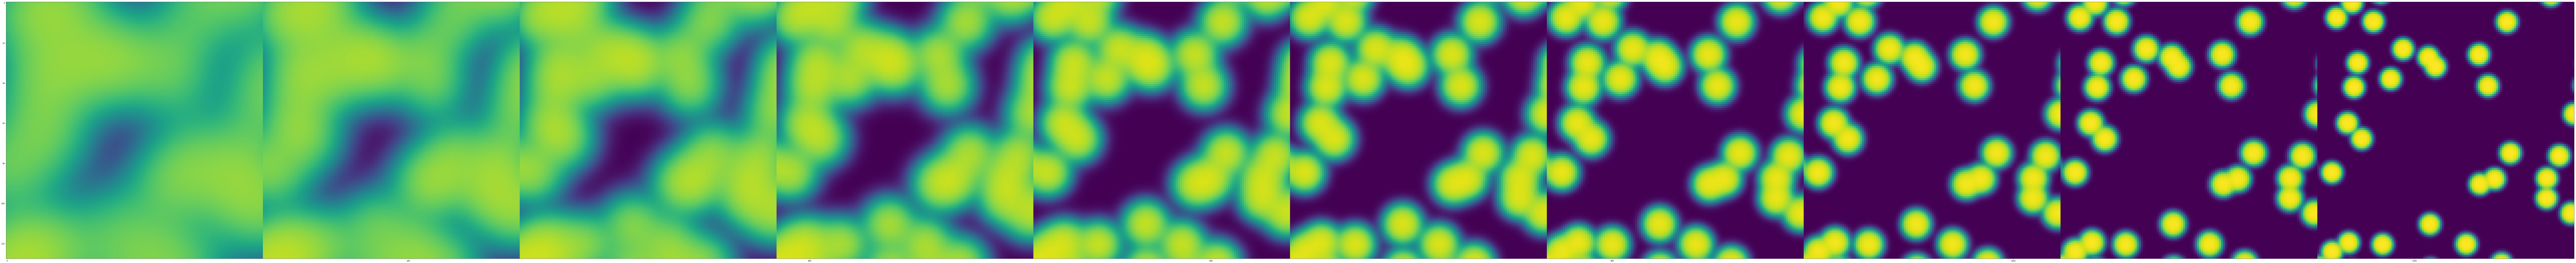

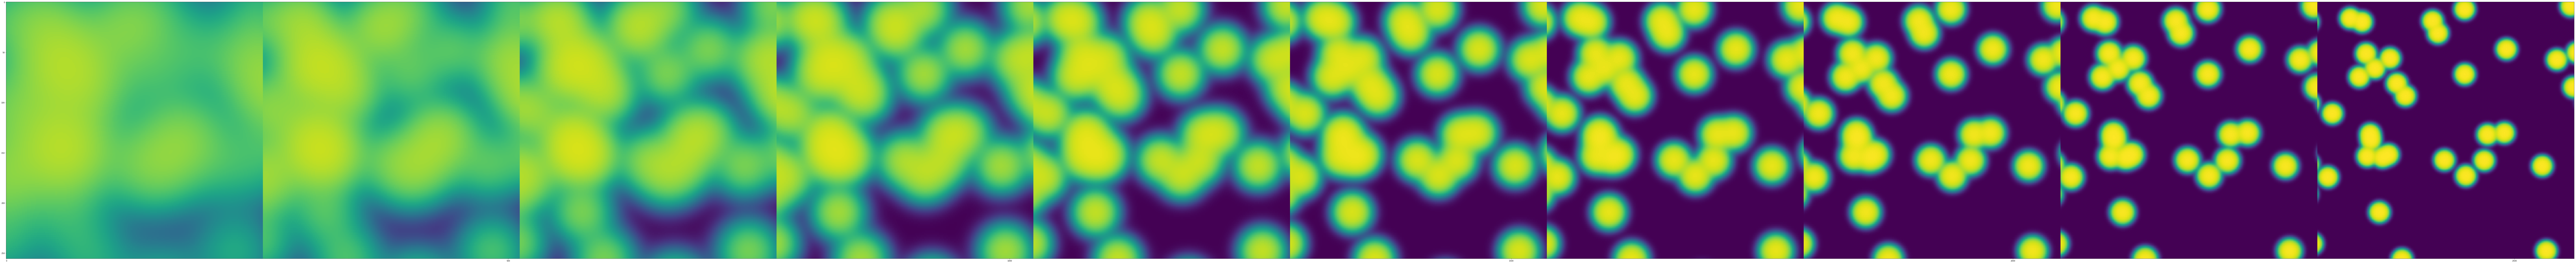

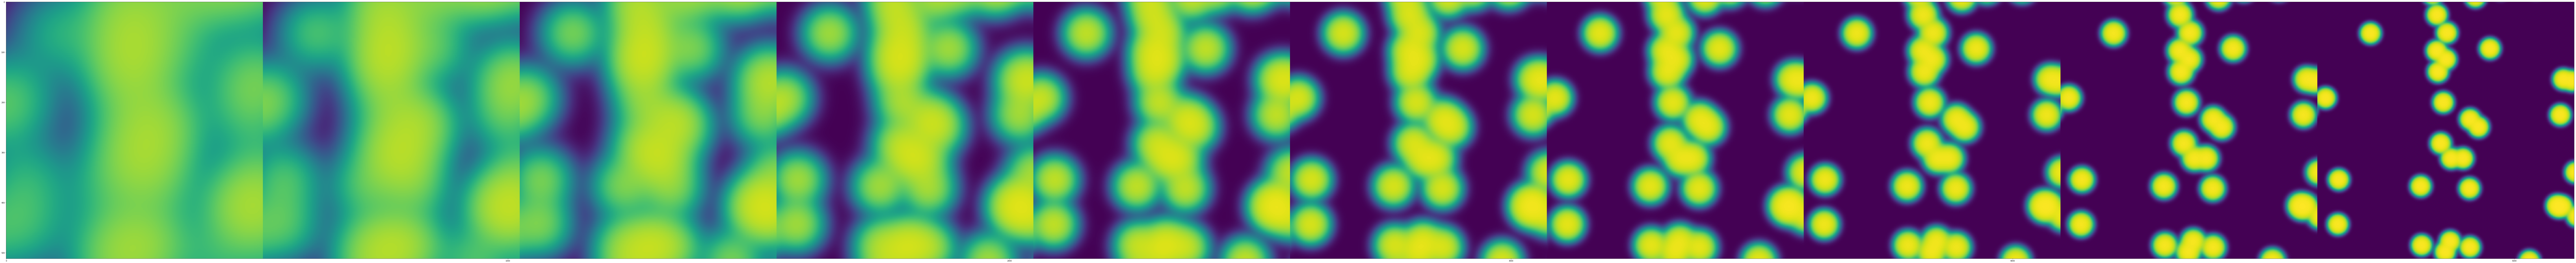

In [5]:
for data in data_lst:
    fig, ax = plt.subplots(figsize=(256, 20))
    ax.imshow(np.hstack(data[0:10]), interpolation=None)
    plt.tight_layout()

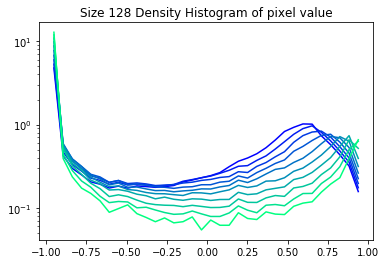

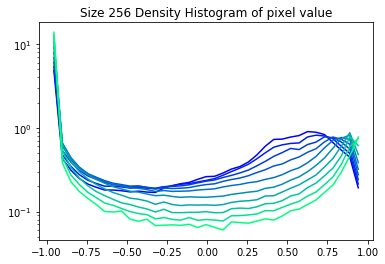

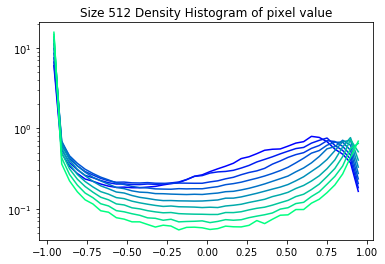

<Figure size 432x288 with 0 Axes>

In [16]:
for data in data_lst:
    _, bins = np.histogram(data, density=True, bins='doane')
    #bins[0] = -1
    #print(bins)
    a = (bins[1:] + bins[:-1]) / 2
    size = data.shape[1] * data.shape[1]
    for i in range(10):
        hist_r,_ = np.histogram(data[i:10:], density=True, bins=bins)
        #plt.subplot(1,2,1)
        plt.plot(a, hist_r, '-', c=cmap[i])
        #plt.subplot(1,2,2)
        #plt.plot(a, np.log(hist_r), '-')
    plt.title("Size {} Density Histogram of pixel value".format(data.shape[1]))
    plt.yscale("log")
    plt.figure()

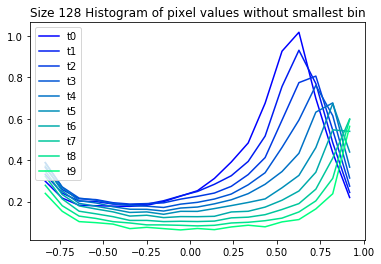

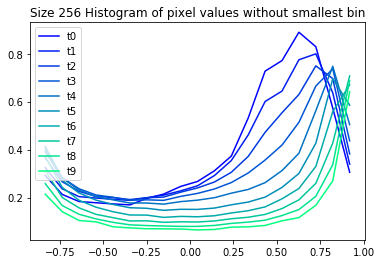

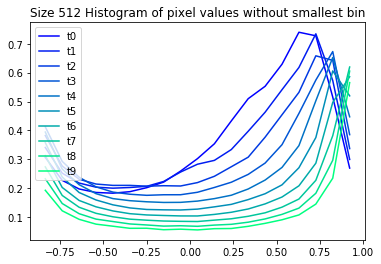

<Figure size 432x288 with 0 Axes>

In [17]:
for data in data_lst:
    _, bins = np.histogram(data, bins=20)
    a = (bins[1:] + bins[:-1]) / 2
    size = data.shape[1] * data.shape[1]
    for i in range(10):
        hist_r,_ = np.histogram(data[i:10:], density=True, bins=bins)
        plt.plot(a[1:], hist_r[1:], '-', label="t{}".format(i), c=cmap[i])
    plt.title("Size {} Histogram of pixel values without smallest bin".format(data.shape[1]))
    plt.legend(loc=2)
    plt.figure()

t0 Wasserstein distance 0-1: 0.04090311641835857
t0 Wasserstein distance 1-2: 0.13759838837160784
t1 Wasserstein distance 0-1: 0.0451500442081791
t1 Wasserstein distance 1-2: 0.13532681811113167
t2 Wasserstein distance 0-1: 0.06899752786895158
t2 Wasserstein distance 1-2: 0.12691041874591605
t3 Wasserstein distance 0-1: 0.0953610443910737
t3 Wasserstein distance 1-2: 0.15161277115510222
t4 Wasserstein distance 0-1: 0.10933542383078551
t4 Wasserstein distance 1-2: 0.24102961945458956
t5 Wasserstein distance 0-1: 0.07607885527922782
t5 Wasserstein distance 1-2: 0.2782622522879598
t6 Wasserstein distance 0-1: 0.029346795691193153
t6 Wasserstein distance 1-2: 0.24387380143171705
t7 Wasserstein distance 0-1: 0.06946111315662948
t7 Wasserstein distance 1-2: 0.17410315646605226
t8 Wasserstein distance 0-1: 0.06772010723641092
t8 Wasserstein distance 1-2: 0.14165294549688676
t9 Wasserstein distance 0-1: 0.046350699414934395
t9 Wasserstein distance 1-2: 0.12530268689789473


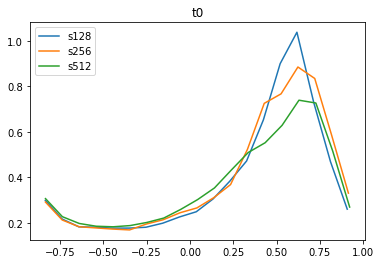

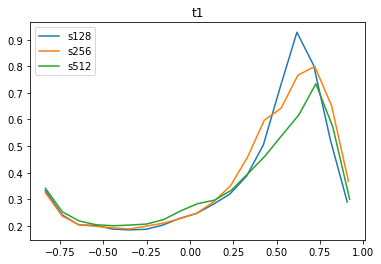

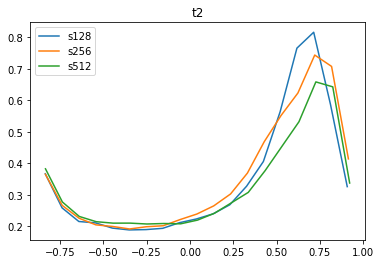

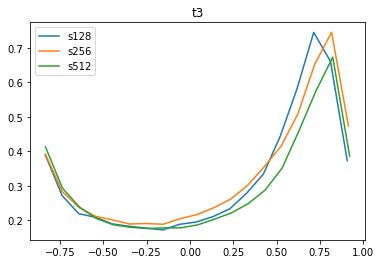

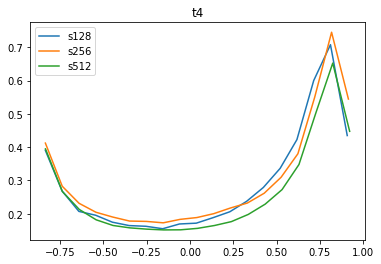

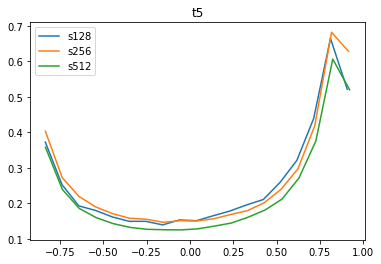

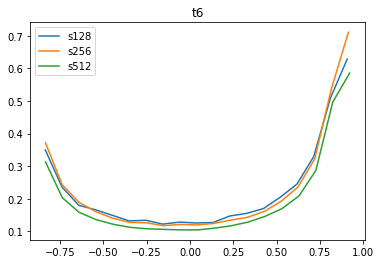

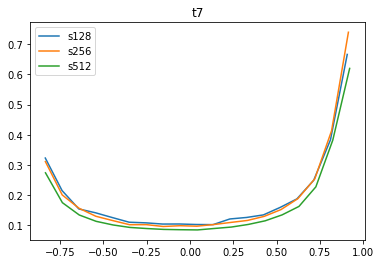

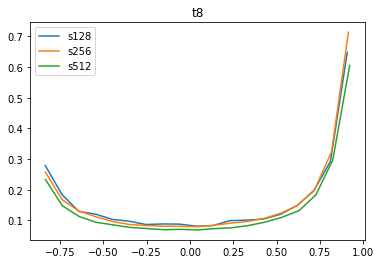

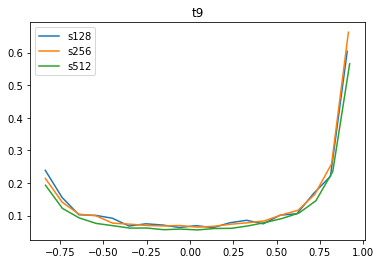

In [18]:
for t in range(10):
    plt.figure()
    h_list = []
    for data in data_lst:
        hist, bins = np.histogram(data[t:10:], density=True, bins=20)
        h_list.append(hist)
        x = (bins[1:] + bins[:-1]) / 2
        plt.plot(x[1:], hist[1:], '-', label="s{}".format(data.shape[1]))
    for idx in range(len(h_list) - 1):
        print("t{} Wasserstein distance {}-{}: {}".format(t, idx, idx+1, wasserstein_distance(h_list[idx][1:], h_list[idx+1][1:], x[1:])))
    plt.legend(loc=2)
    plt.title("t{}".format(t))

/home/jonathan/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


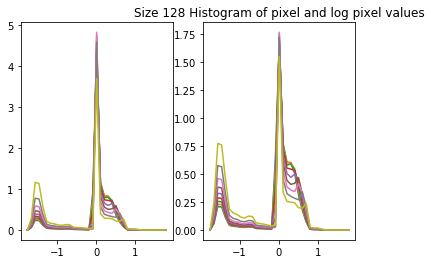

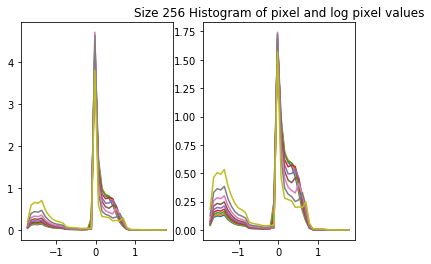

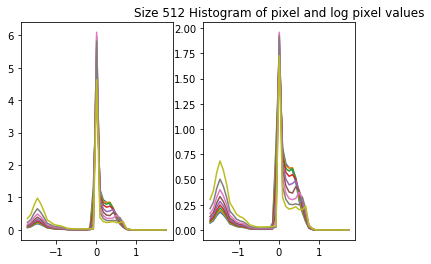

<Figure size 432x288 with 0 Axes>

In [9]:
for data in data_lst:
    diffs_r = data[:-1] - data[1:]
    _, bins = np.histogram(diffs_r, density=True, bins='doane')
    a = (bins[1:] + bins[:-1]) / 2
    for i in range(10-1):
        hist_dr = np.histogram(diffs_r[i:10:], density=True, bins=bins)
        plt.subplot(1,2,1)
        plt.plot(a, hist_dr[0], '-')
        plt.subplot(1,2,2)
        plt.plot(a, np.log(hist_dr[0] + 1), '-')
    plt.title("Size {} Histogram of pixel and log pixel values".format(data.shape[1]))
    plt.figure()

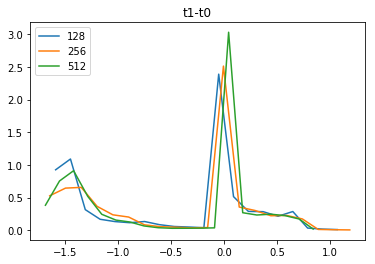

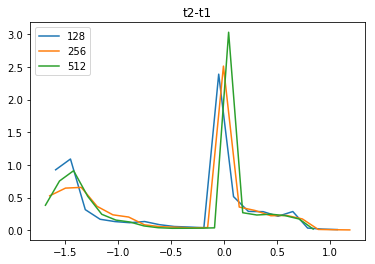

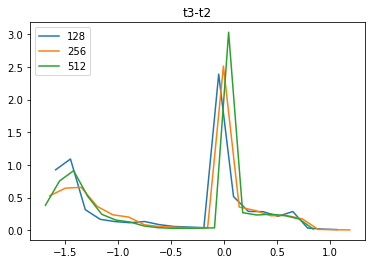

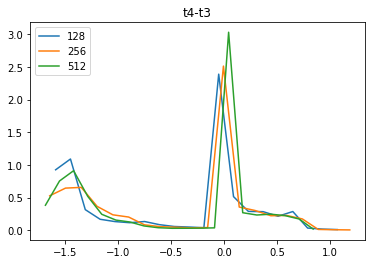

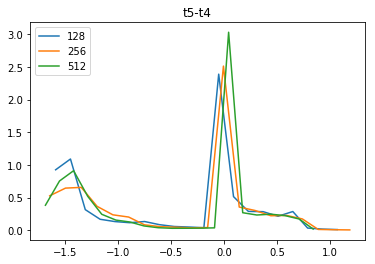

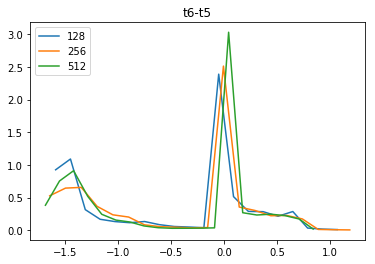

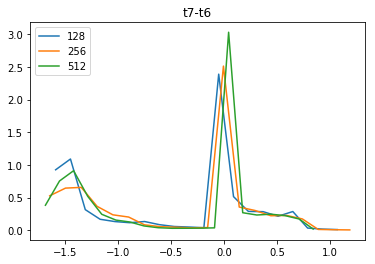

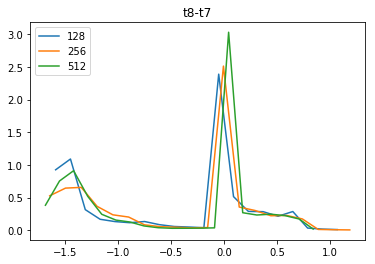

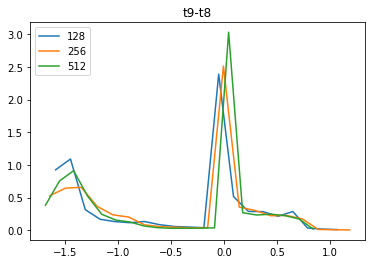

In [10]:
diffs_lst = []
for data in data_lst:
    diffs_lst.append(data[:-1] - data[1:])
for t in range(10-1):
    plt.figure()
    plt.title("t{}-t{}".format(t+1, t))
    for diff in diffs_lst:
        hist, bins = np.histogram(diff[i:10:], density=True, bins=20)
        a = (bins[1:] + bins[:-1]) / 2
        plt.plot(a, hist, label=diff.shape[1])
    plt.legend(loc=2)

In [14]:
m = get_cmap('cool', 10)
print(m)

[[0.         1.         1.         1.        ]
 [0.11111111 0.88888889 1.         1.        ]
 [0.22222222 0.77777778 1.         1.        ]
 [0.33333333 0.66666667 1.         1.        ]
 [0.44444444 0.55555556 1.         1.        ]
 [0.55555556 0.44444444 1.         1.        ]
 [0.66666667 0.33333333 1.         1.        ]
 [0.77777778 0.22222222 1.         1.        ]
 [0.88888889 0.11111111 1.         1.        ]
 [1.         0.         1.         1.        ]]
